# Reproduce figures and tables from _The latent cognitive structures of social networks_ 
This notebook was written to accompany the manuscript _The latent cognitive structures of social networks_ (Aguiar, Ugander 2023). Here, we document the code necessary for replicating the plots and likelihood ratio tests from the work. Detailed explanations of each function used can be found in the `CSS_NNTuck_Code_Tutorial` file.

This notebook depends on `numpy`, `tensorly`, `sklearn`, and `matplotlib`. When sweeping over parameters $K$ and $C$ in NNTuck it is most efficient to run the sweep in parallel, which depends on `joblib` and on `os` to make sure the parallel runs don't use too much CPU. In this tutorial we only sweep over one possible combination of parameters $(K,C)$, but the code is still written in parallel to easily adapt for a more comprehensive sweep. Specific version numbers for which this code runs are in the readme.

Please email me at `izzya@stanford.edu` with _any_ questions at all about this tutorial or the code associated with it!

### Import libraries and external definitions

In [2]:
import NNTucktools
import numpy as np
from NNTucktools import non_negative_tucker, non_negative_tucker_SCagreement, non_negative_tucker_ones, KL_D, max_like, GenerateSBM, Y_interp
import tensorly as tl
from sklearn.metrics import roc_auc_score
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.base import unfold
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from matplotlib.ticker import MaxNLocator
from tensorly.tenalg import mode_dot
import scipy
import copy
import pyreadr
import networkx as nx
import ast
import matplotlib.cm as cmx

### Load the adjacency tensors
For this code tutorial we focus on the CSS dataset from [Krackhardt (1987)](https://bebr.ufl.edu/sites/default/files/Cognitive%20Social%20Strucutres.pdf), and HUNTER.

In [3]:
from numpy import genfromtxt
krack = np.zeros((21,21,21))
for j in range(1,22):
    p = str(j)
    filename = 'krackhardt_data/krack_' + p + '.csv'
    krack_temp = genfromtxt(filename, delimiter=',')
    krack[j-1, :, :] = krack_temp

In [4]:
krack_f = np.load('krack_friend.npy')
krack_a = np.load('krack_advice.npy')
krackf_and = np.sum(krack_f, axis = 0)
krackf_and[np.where(krackf_and > 1)] = 1
krackf_Network = nx.from_numpy_array(krackf_and)
kracka_and = np.sum(krack_a, axis = 0)
kracka_and[np.where(kracka_and > 1)] = 1
kracka_Network = nx.from_numpy_array(kracka_and)

In [5]:
from numpy import loadtxt
N = 20
W = 6
hunter_f = np.zeros((W, N, N, N))
hunter_a = np.zeros((W, N, N, N))

p = str(1)
ad_filename = 'Hunter_Data/Friendship_Week_' + p + '.csv'
friend_bf = loadtxt(ad_filename, delimiter=',', dtype = str)
IDs = [int(friend_bf[0][i]) for i in range(5,25)]
race = [[], [], [], [], [] ,[]]
gender = [[],[]]
g_code = ['M', 'F']
r_code = ['BLACK', 'HISPN', 'ASIAN', 'MULTI', 'AM-IND', 'WHITE']
seen = []
for row in range(1, len(friend_bf)):
    person = int(friend_bf[row][3])
    person_ID = IDs.index(person)
    if person not in seen:
        g = g_code.index(friend_bf[row][0])
        r = r_code.index(friend_bf[row][1])
        gender[g].append(person_ID)
        race[r].append(person_ID,)
        seen.append(person)
for w in range(1, W+1):
    p = str(w)
    ad_filename = 'Hunter_Data/Advice_Week_' + p + '.csv'
    fr_filename = 'Hunter_Data/Friendship_Week_' + p + '.csv'
    advice_bf = loadtxt(ad_filename, delimiter=',', dtype = str)
    friend_bf = loadtxt(fr_filename, delimiter=',', dtype = str)

    for row in range(1, len(advice_bf)):
        ad_imp = [int(advice_bf[row][i]) for i in range(3,25)]
        layer = IDs.index(ad_imp[0])
        ego = IDs.index(ad_imp[1])
        hunter_a[w-1][layer][ego, :] = ad_imp[2:]

    for row in range(1, len(friend_bf)):
        fr_imp = [int(friend_bf[row][i]) for i in range(3,25)]
        layer = IDs.index(fr_imp[0])
        ego = IDs.index(fr_imp[1])
        hunter_f[w-1][layer][ego, :] = fr_imp[2:]

In [52]:
friend_truth_1 = loadtxt('Hunter_Data/Friends_Truth_Week_1.csv', delimiter=',', dtype = int)
advice_truth_1 = loadtxt('Hunter_Data/Advice_Truth_Week_1.csv', delimiter=',', dtype = int)
ad_network1 = nx.from_numpy_array(advice_truth_1)
fr_network1 = nx.from_numpy_array(friend_truth_1)
pos_hunter = {0: np.array([ 0.27597252, -0.1059376 ]),
 1: np.array([-0.2955715 , -0.09188294]),
 2: np.array([0.39465522, 0.4407328 ]),
 3: np.array([0.1966574 , 0.12137404]),
 4: np.array([0.36557986, 0.03546376]),
 5: np.array([-0.15456602,  0.39196922]),
 6: np.array([ 0.0796158 , -0.05048621]),
 7: np.array([-0.89695798,  0.42876465]),
 8: np.array([0.04173719, 0.45805995]),
 9: np.array([ 0.51220661, -0.15309619]),
 10: np.array([ 0.19773229, -0.20468256]),
 11: np.array([-0.37262401, -0.41961076]),
 12: np.array([-0.06318882, -0.14665927]),
 13: np.array([0.08960806, 0.22502369]),
 14: np.array([-0.06910146, -0.01697797]),
 15: np.array([0.05532406, 0.09383832]),
 16: np.array([-0.01105625, -0.33156466]),
 17: np.array([-0.01028536, -1.        ]),
 18: np.array([-0.28284734,  0.16337977]),
 19: np.array([-0.05289025,  0.16229197])}

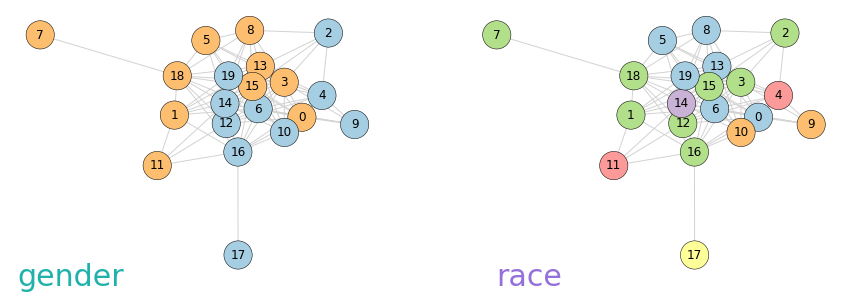

In [51]:
friend_truth_6 = loadtxt('Hunter_Data/Friends_Truth_Week_6.csv', delimiter=',', dtype = int)
advice_truth_6 = loadtxt('Hunter_Data/Advice_Truth_Week_6.csv', delimiter=',', dtype = int)
ad_network = nx.from_numpy_array(advice_truth_6)
fr_network = nx.from_numpy_array(friend_truth_6)
pos = {0: np.array([0.14398204, 0.67120675]),
 1: np.array([0.11839553, 0.26975363]),
 2: np.array([-0.59528823,  0.84744776]),
 3: np.array([-0.54738963,  0.25365929]),
 4: np.array([ 0.84802732, -0.27560054]),
 5: np.array([ 0.28470199, -0.44132085]),
 6: np.array([-0.01455318,  0.06581902]),
 7: np.array([0.96565727, 0.25386217]),
 8: np.array([-0.15665468, -0.41470634]),
 9: np.array([ 0.27006541, -0.73735467]),
 10: np.array([-0.32606193,  0.43905169]),
 11: np.array([-0.44885761,  0.08847577]),
 12: np.array([-0.3465751 , -0.28759149]),
 13: np.array([-0.2469192,  0.7447331]),
 14: np.array([-0.53589258, -0.23669964]),
 15: np.array([-0.18453015,  0.19998342]),
 16: np.array([ 0.06178715, -0.33538839]),
 17: np.array([ 0.0094389, -1.       ]),
 18: np.array([ 0.51389975, -0.1663787 ]),
 19: np.array([0.18676692, 0.06104802])}

In [7]:
kracknets = pyreadr.read_r('kracknets.rda')

depts = np.array(kracknets['attributes']['DEPT'])
tenure = np.array(kracknets['attributes']['TENURE'])
age = np.array(kracknets['attributes']['AGE'])
level = np.array(kracknets['attributes']['LEVEL'])

kracknetrepnp = np.array(kracknets['reports_to_data_frame'])
kracknetrepnp[:, (0,1)] = kracknetrepnp[:, (0,1)] - 1

kracknet_report_adj = np.zeros((21,21))
for l in range(441):
    i = kracknetrepnp[l][0]
    j = kracknetrepnp[l][1]
    k = kracknetrepnp[l][2]
    kracknet_report_adj[i,j] = k

In [8]:
posrep = {0: np.array([ 0.36704917, -0.87309407]),
 1: np.array([ 0.25198734, -0.53055533]),
 2: np.array([-0.89587249, -0.19925205]),
 3: np.array([ 0.51139739, -0.70950406]),
 4: np.array([-0.53020225, -0.28623758]),
 5: np.array([0.95174082, 0.30093429]),
 6: np.array([0.08891742, 0.01561021]),
 7: np.array([0.78723949, 0.42963133]),
 8: np.array([-0.8475622 ,  0.10490396]),
 9: np.array([0.23667186, 0.81803294]),
 10: np.array([0.00744397, 0.83504216]),
 11: np.array([1.        , 0.10694856]),
 12: np.array([-0.83146648,  0.27821425]),
 13: np.array([-0.58488428, -0.00903106]),
 14: np.array([-0.59108917,  0.28617441]),
 15: np.array([ 0.14753465, -0.83684102]),
 16: np.array([ 0.87820785, -0.06696584]),
 17: np.array([0.10584601, 0.51693399]),
 18: np.array([-0.74074995, -0.30333086]),
 19: np.array([-0.9704296 , -0.01727718]),
 20: np.array([0.65822045, 0.13966293])}
#nx.spring_layout(krack_Network_report, k=0.1)#, pos = {17: np.array([])})

In [9]:
krack_las = np.zeros((21,21))
for i in range(21):
    for j in range(21):
        krack_las[i, j]= krack[i, i, j]
krack_and = np.sum(krack, axis = 0)
krack_and[np.where(krack_and < 1)] = 0
krack_and[np.where(krack_and >= 1)] = 1

krack_CS = np.sum(krack, axis = 0)
krack_CS[np.where(krack_CS < 10.5)] = 0
krack_CS[np.where(krack_CS >= 10.5)] = 1

In [10]:
def Plot_Comm(Network, C, position = None):
    cmap = cmx.get_cmap(name='Set3')
    N = len(Network.nodes())
    K = len(C)
    color_map = ['k']*N
    for i in range(K):
        for j in range(len(C[i])):
            color_map[ C[i][j] ] = cmap(i/K)
    if position is None:
        pos = nx.spring_layout(Network, k=0.25,iterations=20)
    else:
        pos = position
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(5)
    nx.draw(Network, pos, node_color=color_map, node_size=800, edge_color='grey', with_labels=True)
    plt.show()
    if position is None:
        return pos
    else:
        return

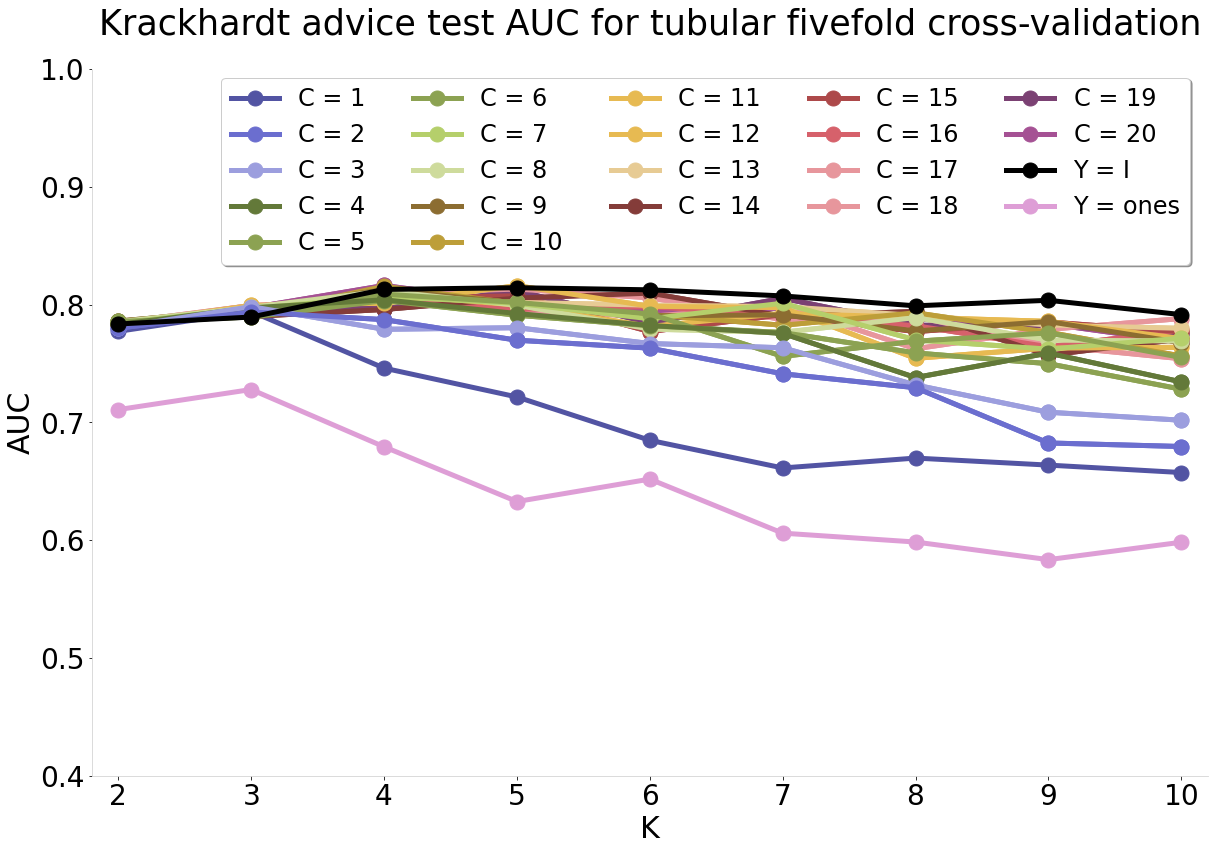

In [172]:
avg_AUCs_krack_chunka = np.load('avg_AUCs_krack_chunka.npy')
avg_krack_ones_AUCa_chunk = np.load('avg_krack_ones_AUCa_chunk.npy')

c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 25)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for ell in range(2,22):
    col = colors[ell]
    axis.plot(range(2,11),avg_AUCs_krack_chunka[:, ell-1], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell-1]))
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
    
for ell in range(21, 2, -1):
    col = colors[ell]
    axis.plot(range(2,11),avg_AUCs_krack_chunka[:, ell-1], lw = 5, marker='o', markersize= 15, c=col)
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
axis.plot(range(2,11),avg_AUCs_krack_chunka[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.4, 1)
axis.set_xlim(1.8, 10.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,11), avg_krack_ones_AUCa_chunk, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')
#axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, .95),
          #ncol=5, fancybox=True, shadow=True)
axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, 1.005),
          ncol=5, fancybox=True, shadow=True)
axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Krackhardt advice test AUC for tubular fivefold cross-validation',fontsize=35, pad=35)
# axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, .995),
#           ncol=5, fancybox=True, shadow=True)
plt.savefig('kracka_chunk_sweep_legend.pdf', pad_inches=0.05)

## Estimating an NNTuck 


In [11]:
def multistart(tensor, C, K, masked, Mask, Sym, NUM_IT, ms_type = 'reg'):
    if masked:
        assert np.shape(tensor) == np.shape(Mask), "size of tensor and Mask must be the same"
    if ms_type == 'Ind':
        return multi_nntuck_ind(tensor, C, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'Red':
        assert C == 1, "for a Redundant NNTuck, C must be equal to 1"
        return multi_nntuck_ones(tensor, C, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'SCA':
        return multi_nntuck_sca(tensor, K, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'reg':
        return multi_nntuck(tensor, C, K, masked, Mask, Sym, NUM_IT)
    else:
        print("ms_type must be one of: Ind, Red, SCA, reg")
        return
    
def multi_nntuck_ones(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker_ones(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker_ones(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]

    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck_ind(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker(tensor, rank = [ALPHA, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker(tensor, rank = [ALPHA, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]

    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=False, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=False, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]
    
    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck_sca(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
    B = K
    if C<K:
        B =C
    #C = K    
    tuck, logl, kld, kld_u, kld_min_ind = non_negative_tucker_SCagreement(tensor, rank = [B, B, B], init='random', n_iter_max=1000,
                                                             symmetric = False, masked = masked, Masking = Mask,
                                                                          socog = True,
                                                      MT_stopping_conditions = True, returnErrors = True,
                                                                              averaged = True,
                                                        verbose=False, constrained=False, loss = 'KL', tol=10e-8)
    max_logl = logl[kld_min_ind]
    max_tuck = tuck
    max_kld = kld[kld_min_ind]

    for i in range(1, NUM_IT):
        tuck, logl, kld, kld_u, kld_min_ind = non_negative_tucker_SCagreement(tensor, rank = [B, B, B], init='random', n_iter_max=1000,
                                                             symmetric = False, masked = masked, Masking = Mask,
                                                                              socog = True,
                                                      MT_stopping_conditions = True, returnErrors = True,
                                                                              averaged = True,
                                                        verbose=False, constrained=False, loss = 'KL', tol=10e-8)
        if logl[kld_min_ind] > max_logl: 
            max_logl = logl[kld_min_ind]
            max_tuck = tuck
            max_kld = kld[kld_min_ind]
    
    core, factors = max_tuck
    return core, factors, max_logl

## Likelihood Ratio Tests
The below function definitions are to perform both the standard LRT as well as the split-LRT from the Universal Inference (Wasserman et al., 2021) work. 


In [12]:
def log_like(tensor, core, factors, masked = False, M = None):
    # Returns the log-likelihood over just the observed entries (M = 1)
    B = tucker_to_tensor((core, factors), transpose_factors= False)
    if masked:
        B = M * B
    mask = B > 0
    return np.sum(np.where(mask, tensor*np.log(B, where=mask)-B, 0))

In [13]:
def reg_LRT(tensor, C, K, M = None, R = False, Symmetric = False, SCA = False, Ind = False, alpha = 0.05):
    # tensor is our multilayer network
    # M splits the data in two: M_0 (where M==0) and M_1, (where M==1)
    # K, C determine the latent dimensions of the nested model
    # Redundant = True if the nested model is the redundant NNTuck
    # Symmetric = True if the network is undirected
    # alpha is significance level for split LRT
    # need: core_0, factors_0, ll_0, the (ideally upper bounded) max likelihood estimat(e/ors) under the nested model
        # core_0, factors_0, and ll_0 are all from  nested model and only evaluated on/from M_0
    # need: core_1, factors_1, ll_1, any estimators under the full model and corr. log_likelihood
        # core_1, factors_1, and ll_1 are all from full model and only evaluated on/from M_1
        
    # core_0, factors_0 are the NNTuck(C,K) corresponding to the highest log-likelihood over 50 runs
    ALPHA, N, N = np.shape(tensor)
    L = ALPHA
    if Ind:
        ms_type_full = 'Ind'
        full_string = "Independent"
    else:
        ms_type_full = 'reg'
        full_string = "dependent with C = " + str(C) + ", K = " + str(K)
    if R:
        ms_type_nest = 'Red'
        nest_string = "Redundant"
    if SCA:
        ms_type_nest = 'SCA'
        nest_string = "social-cognitive agreement with K = C = "+ str(K)
    elif Ind and not R and not SCA:
        ms_type_nest = 'reg'
        nest_string = "dependent with C = " + str(C) + ", K = " + str(K)
        
    core_0, factors_0, ll_0 = multistart(tensor, C, K, masked = False, Mask = None, ms_type = ms_type_nest, 
                                         Sym = Symmetric, NUM_IT = 50)

    core_1, factors_1, ll_not1 = multistart(tensor, C, K, masked = False, Mask = None, 
                                            Sym = Symmetric, ms_type = ms_type_full, NUM_IT = 20)
    
    print("nested log like is {}, full log like is {}".format(ll_0,ll_not1))
    
    if SCA and Ind:
        deg = K*K*(N-K)
    elif SCA and not Ind:
        #deg = L*C + K*K*C - K*K*K
        B = K #B is the K,C, NOW K, C are K' C'
        if C<K:
            B = C
        deg = 2*N*(K-B) + K*K*C + C*N - B*B*B
    elif R and Ind:
        deg = (L-1)*K*K
    elif Ind and not R and not SCA:
        deg = (L-C)*K*K - L*C
        
    print("{} degrees of freedom \n".format(deg))
    LR_statistic = -2*(ll_0-ll_not1)
    lrt_reg = scipy.stats.chi2.sf(LR_statistic, deg)
    print("the p value for the regular LRT is {}\n".format(lrt_reg))    
    if lrt_reg <= alpha:
        print("The LRT ({} <= {}) rejects the null: this network is {} at sig level alpha ".format(lrt_reg, alpha, full_string))
        reject = True
    else:
        print("The LRT ({} > {}) fails to reject the null: this network is {} at sig level alpha ".format(lrt_reg, alpha, nest_string))
        reject = False
    return lrt_reg, reject

In [14]:
def masking_tensor_UI_LRT(tensor): 
    # This function returns a masking tensor for a **directed** network (e.g., M == M.T)
        # here, M_ijk == 0 means that A_ijk is _unobserved_ 
        # In each of the M's with uniform probability a 
        # random set of ~50% of the entries are unobserved
        # here if M_ijk is unobserved, so is M_jik
        
    M_1 = np.ones_like(tensor)
    M_2 = np.ones_like(tensor)
    
    ALPHA, N, N = np.shape(tensor)
    M_fold = np.random.rand(ALPHA, N, N)

    M_1[np.where(np.logical_and(np.triu(M_fold) <= 0.5, np.triu(M_fold) > 0.0))] = 0
    a=np.where(M_1 == 0)
    b = tuple((a[0], a[2], a[1]))
    M_1[b] = 0

    M_2[np.where(np.logical_and(np.triu(M_fold) <= 1, np.triu(M_fold) > 0.5))] = 0
    a=np.where(M_2 == 0)
    b = tuple((a[0], a[2], a[1]))
    M_2[b] = 0

    Maskings = [M_1, M_2]
    return Maskings

In [15]:
def masking_tensor(tensor):
    # This function returns 5 masking tensors for a **directed** network (e.g., M != M.T)
        # here, M_ijk == 0 means that A_ijk is _unobserved_ 
        # In each of the M's with uniform probability a 
        # random set of ~20% of the entries are unobserved
        
    ALPHA, N, N = np.shape(tensor)
    M_fold = np.random.rand(ALPHA, N, N)
    
    M_1 = np.ones_like(tensor)
    M_2 = np.ones_like(tensor)

    M_1[np.where(M_fold<=0.5)] = 0
    M_2[np.where(M_fold > 0.5)] = 1

    Maskings = [M_1, M_2]
    return Maskings

In [16]:
def split_LRT(tensor, C, K, M, R = False, Symmetric = False, SCA = False, Ind = False, alpha = 0.05):
    # tensor is our multilayer network
    # M splits the data in two: M_0 (where M==0) and M_1, (where M==1)
    # K, C determine the latent dimensions of the nested model
    # Redundant = True if the nested model is the redundant NNTuck
    # Symmetric = True if the network is undirected
    # alpha is significance level for split LRT
    # need: core_0, factors_0, ll_0, the (ideally upper bounded) max likelihood estimat(e/ors) under the nested model
        # core_0, factors_0, and ll_0 are all from  nested model and only evaluated on/from M_0
    # need: core_1, factors_1, ll_1, any estimators under the full model and corr. log_likelihood
        # core_1, factors_1, and ll_1 are all from full model and only evaluated on/from M_1
        
    # core_0, factors_0 are the NNTuck(C,K) corresponding to the highest log-likelihood over 50 runs
    ALPHA, N, N = np.shape(tensor)
    L = ALPHA
    M0 = np.ones_like(M) - M
    
    if Ind:
        ms_type_full = 'Ind'
        full_string = "Independent"
    else:
        ms_type_full = 'reg'
        full_string = "dependent with C = " + str(C) + ", K = " + str(K)
    if R:
        ms_type_nest = 'Red'
        nest_string = "Redundant"
    if SCA:
        ms_type_nest = 'SCA'
        nest_string = "social-cognitive agreement with K = C = "+ str(K)
    elif Ind and not R and not SCA:
        ms_type_nest = 'reg'
        nest_string = "dependent with C = " + str(C) + ", K = " + str(K)
    
    core_0, factors_0, ll_0 = multistart(tensor, C, K, masked = True, Mask = M0, ms_type = ms_type_nest, 
                                         Sym = Symmetric, NUM_IT = 50)

    core_1, factors_1, ll_not1 = multistart(tensor, C, K, masked = True, Mask = M, 
                                            ms_type = ms_type_full, Sym = Symmetric, NUM_IT = 20)
    
    # ll_1 is the corresponding log likelihood, but evaluated only on M0
    ll_1 = log_like(tensor, core_1, factors_1, masked = True, M = M0)
    split_sig = np.log(1/alpha)
    split_stat = ll_1 - ll_0
      
    if split_stat >= split_sig:
        print("The split LRT ({} >= {}) rejects the null: this network is {} at sig level alpha ".format(split_stat, split_sig, full_string))
        reject = True
    else:
        print("The split LRT ({} < {}) fails to reject the null: this network is {} at sig level alpha ".format(split_stat, split_sig, nest_string))
        reject = False
    return split_stat, reject

### LRTs on Krackhardt Advice CSS

In [181]:
M0, M1 = masking_tensor_UI_LRT(krack)

#### Redundant v Independent, K=3

In [183]:
reg_LRT(krack, 1, 3, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -5299.636888263327, full log like is -4890.772159004494
180 degrees of freedom 

the p value for the regular LRT is 5.642067233592647e-82

The LRT (5.642067233592647e-82 <= 0.05) rejects the null: this network is Independent at sig level alpha 


(5.642067233592647e-82, True)

In [211]:
split_LRT(krack, 1, 3, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-21.699075665413602 < 2.995732273553991) fails to reject the null: this network is Redundant at sig level alpha 


(-21.699075665413602, False)

#### Dependent v Independent, K=3, C = 3

In [185]:
reg_LRT(krack, 3, 3, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -4930.708381940756, full log like is -4875.61722259447
99 degrees of freedom 

the p value for the regular LRT is 0.20794527883978547

The LRT (0.20794527883978547 > 0.05) fails to reject the null: this network is dependent with C = 3, K = 3 at sig level alpha 


(0.20794527883978547, False)

In [210]:
split_LRT(krack, 3, 3, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-664.5611575485132 < 2.995732273553991) fails to reject the null: this network is dependent with C = 3, K = 3 at sig level alpha 


(-664.5611575485132, False)

#### SCA K=C=3 vs Dependent K=3, C=3

In [94]:
reg_LRT(krack, 3, 3, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

nested log like is -5106.730352427055, full log like is -4935.551726448985
63 degrees of freedom 

the p value for the regular LRT is 4.957380084607179e-40

The LRT (4.957380084607179e-40 <= 0.05) rejects the null: this network is dependent with C = 3, K = 3 at sig level alpha 


(4.957380084607179e-40, True)

In [209]:
split_LRT(krack, 3, 3, M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

The split LRT (-142.48484375334056 < 2.995732273553991) fails to reject the null: this network is social-cognitive agreement with K = C = 3 at sig level alpha 


(-142.48484375334056, False)

### Krackhardt Friendship
regular and UI LRT

In [95]:
M0, M1 = masking_tensor_UI_LRT(krack_f)

In [205]:
M0, M1 = masking_tensor(krack_f)

#### Redundant v Independent, K=3

In [96]:
reg_LRT(krack_f, 1, 3, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -2153.7095390249137, full log like is -1905.5020713264457
180 degrees of freedom 

the p value for the regular LRT is 2.075162529104438e-31

The LRT (2.075162529104438e-31 <= 0.05) rejects the null: this network is Independent at sig level alpha 


(2.075162529104438e-31, True)

In [212]:
split_LRT(krack_f, 1, 3, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-2100.820421201291 < 2.995732273553991) fails to reject the null: this network is Redundant at sig level alpha 


(-2100.820421201291, False)

#### Dependent v Independent, K=3, C = 5

In [98]:
reg_LRT(krack_f, 5, 3, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -1911.8971274493733, full log like is -1900.943162277817
39 degrees of freedom 

the p value for the regular LRT is 0.9876143488265371

The LRT (0.9876143488265371 > 0.05) fails to reject the null: this network is dependent with C = 5, K = 3 at sig level alpha 


(0.9876143488265371, False)

In [208]:
split_LRT(krack_f, 5, 3, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-1693.5941280076463 < 2.995732273553991) fails to reject the null: this network is dependent with C = 5, K = 3 at sig level alpha 


(-1693.5941280076463, False)

#### SCA K=C=3 vs Dependent K=3, C=5

In [216]:
reg_LRT(krack_f, C = 5, K = 3, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

nested log like is -2045.8237104634752, full log like is -1909.9921832322752
123 degrees of freedom 

the p value for the regular LRT is 3.128400265684715e-13

The LRT (3.128400265684715e-13 <= 0.05) rejects the null: this network is dependent with C = 5, K = 3 at sig level alpha 


(3.128400265684715e-13, True)

In [217]:
split_LRT(krack_f, C= 5, K = 3, M = M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

The split LRT (-1383.7913410650965 < 2.995732273553991) fails to reject the null: this network is social-cognitive agreement with K = C = 3 at sig level alpha 


(-1383.7913410650965, False)

### Hunter Advice
regular and UI LRT

In [218]:
M0, M1 = masking_tensor(hunter_a[-1])

#### Redundant v Independent, K=2

In [219]:
reg_LRT(hunter_a[-1], C = 1, K = 2, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -3264.927457006113, full log like is -2911.585908369456
76 degrees of freedom 

the p value for the regular LRT is 5.470935279468726e-103

The LRT (5.470935279468726e-103 <= 0.05) rejects the null: this network is Independent at sig level alpha 


(5.470935279468726e-103, True)

In [220]:
split_LRT(hunter_a[-1], C = 1, K = 2, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (11.418309646479429 >= 2.995732273553991) rejects the null: this network is Independent at sig level alpha 


(11.418309646479429, True)

#### Dependent v Independent, K=2, C =3

In [203]:
reg_LRT(hunter_a[-1], C = 3, K = 2, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -2920.6941892666673, full log like is -2911.659158378834
8 degrees of freedom 

the p value for the regular LRT is 0.020707312882948085

The LRT (0.020707312882948085 <= 0.05) rejects the null: this network is Independent at sig level alpha 


(0.020707312882948085, True)

In [221]:
split_LRT(hunter_a[-1], C = 3, K = 2, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-187.5267303074993 < 2.995732273553991) fails to reject the null: this network is dependent with C = 3, K = 2 at sig level alpha 


(-187.5267303074993, False)

#### SCA K=C=2 vs Dependent K=2, C=3

In [222]:
reg_LRT(hunter_a[-1], C = 3, K = 2, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

nested log like is -3106.083252302206, full log like is -2920.4283503816714
64 degrees of freedom 

the p value for the regular LRT is 7.324307124348658e-45

The LRT (7.324307124348658e-45 <= 0.05) rejects the null: this network is dependent with C = 3, K = 2 at sig level alpha 


(7.324307124348658e-45, True)

In [223]:
split_LRT(hunter_a[-1], C= 3, K = 2, M = M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

The split LRT (-102.7543164990609 < 2.995732273553991) fails to reject the null: this network is social-cognitive agreement with K = C = 2 at sig level alpha 


(-102.7543164990609, False)

### Hunter Friendship
regular and UI LRT

In [226]:
M0, M1 = masking_tensor(hunter_f[-1])

#### Redundant v Independent, K=2

In [227]:
reg_LRT(hunter_f[-1], C = 1, K = 2, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -5431.642686384022, full log like is -4797.1286172682185
76 degrees of freedom 

the p value for the regular LRT is 1.0272566755239589e-215

The LRT (1.0272566755239589e-215 <= 0.05) rejects the null: this network is Independent at sig level alpha 


(1.0272566755239589e-215, True)

In [228]:
split_LRT(hunter_f[-1], C = 1, K = 2, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (200.54764089328864 >= 2.995732273553991) rejects the null: this network is Independent at sig level alpha 


(200.54764089328864, True)

#### Dependent v Independent, K=2, C =3

In [229]:
reg_LRT(hunter_f[-1], C = 3, K = 2, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -4801.715604766278, full log like is -4796.87289210559
8 degrees of freedom 

the p value for the regular LRT is 0.28780266837435636

The LRT (0.28780266837435636 > 0.05) fails to reject the null: this network is dependent with C = 3, K = 2 at sig level alpha 


(0.28780266837435636, False)

In [230]:
split_LRT(hunter_f[-1], C = 3, K = 2, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-111.36696748863824 < 2.995732273553991) fails to reject the null: this network is dependent with C = 3, K = 2 at sig level alpha 


(-111.36696748863824, False)

#### SCA K=C=2 vs Dependent K=2, C=3

In [352]:
reg_LRT(hunter_f[-1], C = 2, K = 2, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

nested log like is -4929.694918843305, full log like is -4827.23356675536
40 degrees of freedom 

the p value for the regular LRT is 5.070747226889234e-24

The LRT (5.070747226889234e-24 <= 0.05) rejects the null: this network is dependent with C = 2, K = 2 at sig level alpha 


(5.070747226889234e-24, True)

In [399]:
reg_LRT(hunter_f[0], C = 2, K = 2, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

nested log like is -4815.308744346336, full log like is -4508.920778608703
40 degrees of freedom 

the p value for the regular LRT is 1.315736303769774e-103

The LRT (1.315736303769774e-103 <= 0.05) rejects the null: this network is dependent with C = 2, K = 2 at sig level alpha 


(1.315736303769774e-103, True)

In [354]:
split_LRT(hunter_f[-1], C= 2, K = 2, M = M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

The split LRT (-4.060945846300456 < 2.995732273553991) fails to reject the null: this network is social-cognitive agreement with K = C = 2 at sig level alpha 


(-4.060945846300456, False)

In [401]:
split_LRT(hunter_f[0], C= 2, K = 2, M = M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

The split LRT (85.41063904745806 >= 2.995732273553991) rejects the null: this network is dependent with C = 2, K = 2 at sig level alpha 


(85.41063904745806, True)

## NNTuck of the Krackhardt advice CSS with $K=C=3$
We use 50 random initializations of the multiplicative updates algorithm and examine the social and cognitive structure of the NNTuck corresponding to the highest log-likelihood over these random initializations. 

In [128]:
core, factors, loglike =  multistart(krack_a, 3, 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')

In [ ]:
np.save(core, 'kracka_core')
np.save(factors, 'kracka_factors')

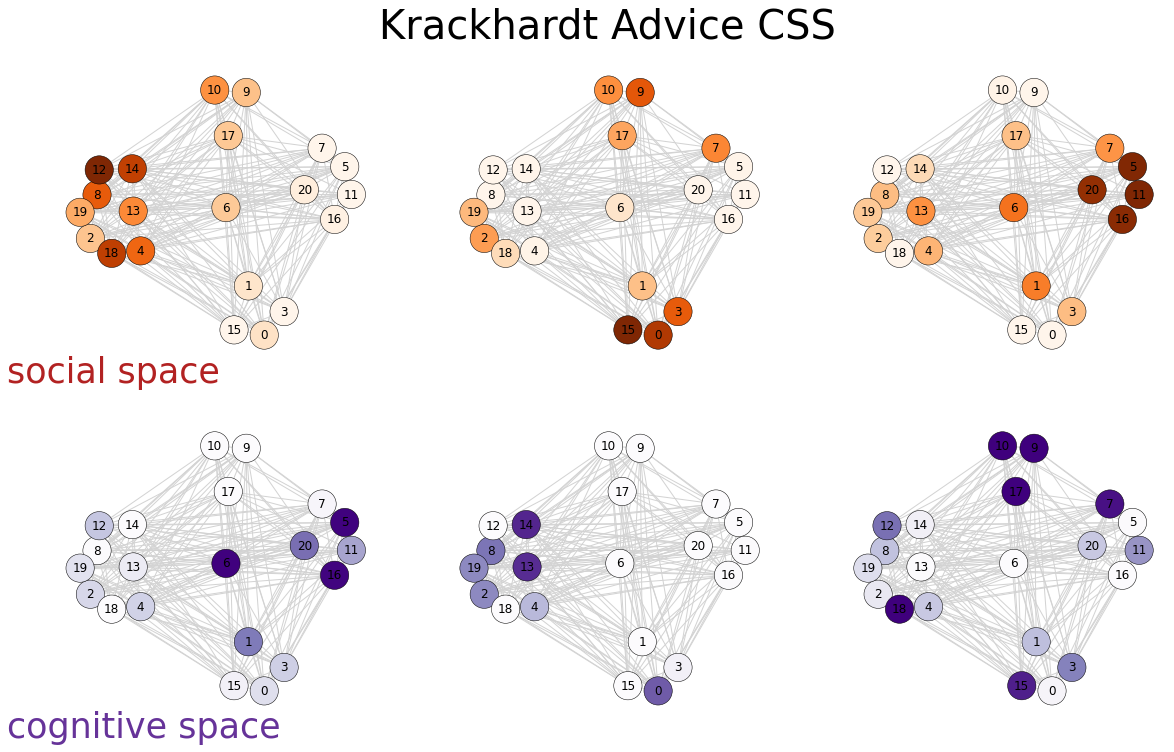

In [141]:
for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krack_and)
    colors_U2 = ['c'] * len(krack_and)
    colors_U3 = ['c'] * len(krack_and)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    
    colors_cogsocdiff = ['c'] * len(krack_and)
    Ytwo, Utwo, Vtwo = factors
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krack_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(kracka_Network, posrep,  ax=axis[0,1], node_color=colors_U3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[0,0], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[0,2], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)

    nx.draw(kracka_Network, posrep,  ax=axis[1,1], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[1,2], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[1,0], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1.2, 1.2, 'Krackhardt Advice CSS', fontsize = 40, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 35, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 35, c = 'rebeccapurple')
    
    filename = 'kracka_cognet_max_3_3.pdf'
    plt.savefig(filename, bbox_inches ='tight')

## Krackhardt Advice SCA

In [133]:
core_SCA, factors_SCA, loglike_SCA =  multistart(krack, 3, 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'SCA')

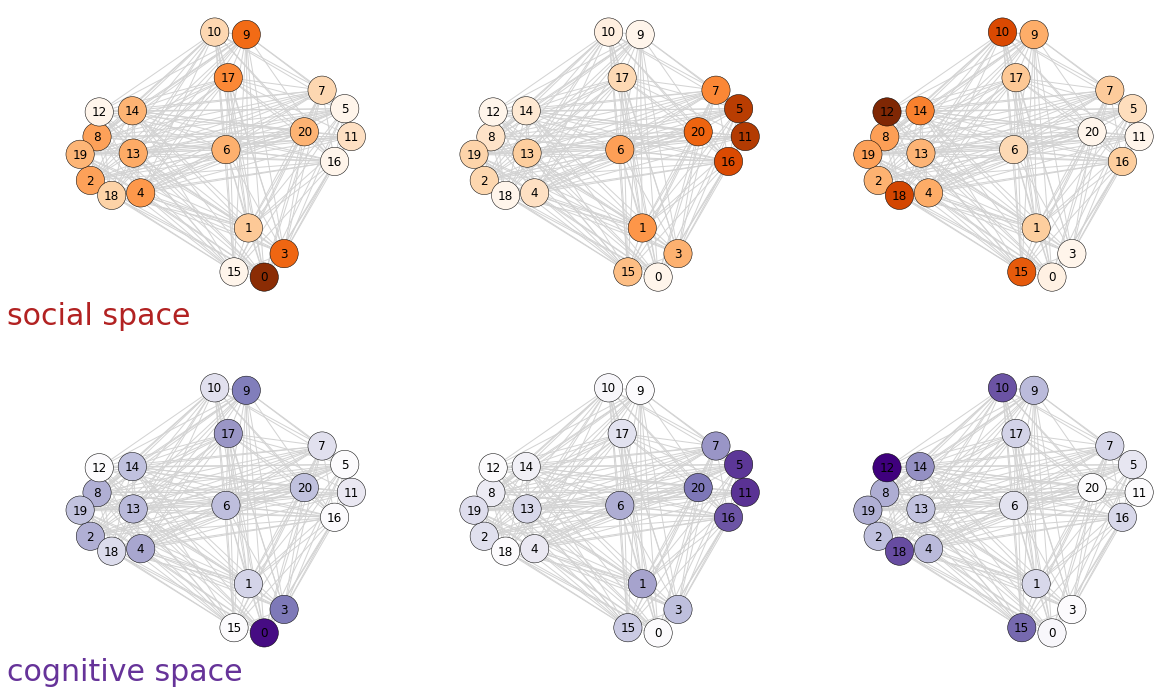

In [142]:
for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krack_and)
    colors_U2 = ['c'] * len(krack_and)
    colors_U3 = ['c'] * len(krack_and)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    Ytwo, Utwo, Vtwo = factors_SCA
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krack_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(kracka_Network, posrep,  ax=axis[0,1], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[0,0], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[0,2], node_color=colors_U3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[1,1], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[1,0], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
#     axis[0,0].text(1, 1.2, 'Krackhardt Advice CSS', fontsize = 3, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 30, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 30, c = 'rebeccapurple')
    
    axis[1,2].axis('off')
    filename = 'kracka_SCA_cognet_max_3_3.pdf'
#     plt.savefig(filename, bbox_inches='tight')
    #plt.close()

## Re-writing $\mathcal{G}$ in the basis of person 6, 14, and 11


In [143]:
def Y_interp(factors, r_star = None, verbose = False):
    Y = factors[0]
    ALPHA, C = np.shape(Y)
    
    Y_star = np.zeros_like(Y)
    r_bar = [r for r in range(ALPHA) if r not in r_star]
    Y_rstar = Y[r_star, :]
    Y_rbar = Y[r_bar, :]
    Y_star[r_star, :] = np.eye(C)
    Y_star[r_bar, :] = np.linalg.solve(Y_rstar.T, Y_rbar.T).T
    
    if verbose:
        with np.printoptions(precision = 4, suppress=True):
            print("True Y is ")
            print("")
            print(Y)
            print("")
            print("Y_norm is")
            print("")
            print(Y/np.sum(Y, axis = 1, keepdims = True))
            print("")
            print("row normalized Y_star is")
            print("")
            print(Y_star/np.sum(abs(Y_star), axis = 1, keepdims = True))
            print("")
                
    return Y_star/np.sum(abs(Y_star), axis = 1, keepdims = True)

In [144]:
Ystar = Y_interp(factors, r_star = [14, 6, 10], verbose = True)

True Y is 

[[0.0385 0.4541 0.1387]
 [0.074  0.0005 0.1274]
 [0.0668 0.2342 0.1086]
 [0.2108 0.0333 0.1044]
 [0.1221 0.1457 0.1081]
 [0.0011 0.0001 0.1042]
 [0.0009 0.0006 0.3172]
 [0.2018 0.0001 0.0114]
 [0.1118 0.2039 0.0003]
 [0.2355 0.     0.0003]
 [0.1209 0.     0.0001]
 [0.1216 0.0023 0.1071]
 [0.0553 0.     0.028 ]
 [0.0005 0.2826 0.0467]
 [0.0264 0.2063 0.001 ]
 [0.071  0.     0.0078]
 [0.0002 0.001  0.0863]
 [0.2262 0.0002 0.    ]
 [0.165  0.     0.    ]
 [0.0409 0.1038 0.0363]
 [0.1205 0.0016 0.2451]]

Y_norm is

[[0.061  0.7193 0.2197]
 [0.3666 0.0023 0.6311]
 [0.1631 0.5718 0.2651]
 [0.6048 0.0954 0.2997]
 [0.3248 0.3876 0.2876]
 [0.0101 0.0007 0.9892]
 [0.0029 0.0018 0.9953]
 [0.9464 0.0003 0.0533]
 [0.3538 0.6452 0.001 ]
 [0.9986 0.     0.0014]
 [0.999  0.0001 0.0009]
 [0.5264 0.01   0.4636]
 [0.6639 0.     0.3361]
 [0.0016 0.8568 0.1416]
 [0.1128 0.8828 0.0044]
 [0.9013 0.     0.0987]
 [0.0018 0.0119 0.9863]
 [0.9991 0.0008 0.0001]
 [0.9997 0.0003 0.    ]
 [0.2258 0.5736

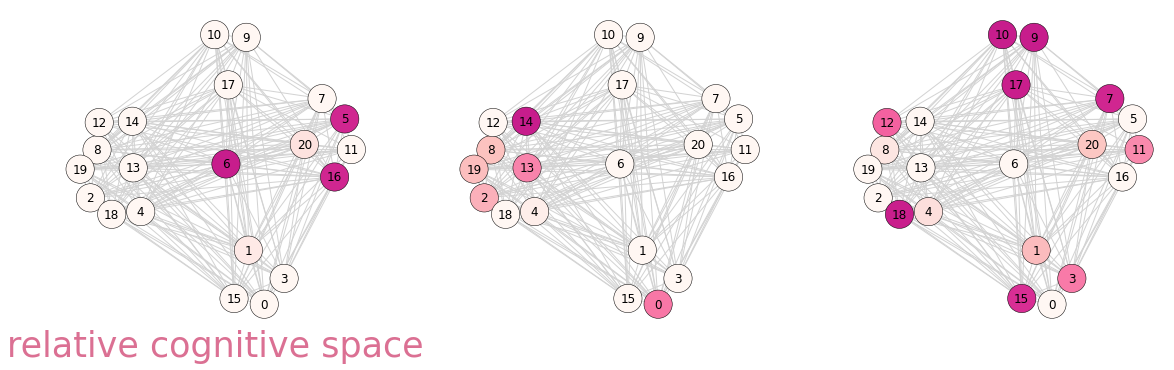

In [147]:
for n in range(1):
    f, axis = plt.subplots(1,3)
    f.set_figheight(6)
    f.set_figwidth(20)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    cmapTwo=plt.get_cmap('RdPu')
    Y_norm = Ystar- 0.32*np.ones(3) # just to make the colour prettier 
    for i in range(len(krack_and)):
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])

    nx.draw(kracka_Network, posrep,  ax=axis[1], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1].collections[0].set_edgecolor("k") 
    axis[1].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[2].collections[0].set_edgecolor("k") 
    axis[2].collections[0].set_linewidths(0.5)
    nx.draw(kracka_Network, posrep,  ax=axis[0], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0].collections[0].set_edgecolor("k") 
    axis[0].collections[0].set_linewidths(0.5)
    
#     axis[0].text(1, 1.2, 'Krackhardt Advice CSS', fontsize = 28, c = 'k')
    axis[0].text(-1.5, -1.2, 'relative cognitive space', fontsize = 35, c = 'palevioletred')
    
    filename = 'kracka_cognet_rel_3_3.pdf'
    plt.savefig(filename, bbox_inches='tight')
    #plt.close()

# Krackhardt Friendship 

In [149]:
core_fr, factors_fr, loglike_fr =  multistart(krack_f, C = 5, K = 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')

In [ ]:
np.save(core_fr, 'krackf_core')
np.save(factors_fr, 'krackf_factors')

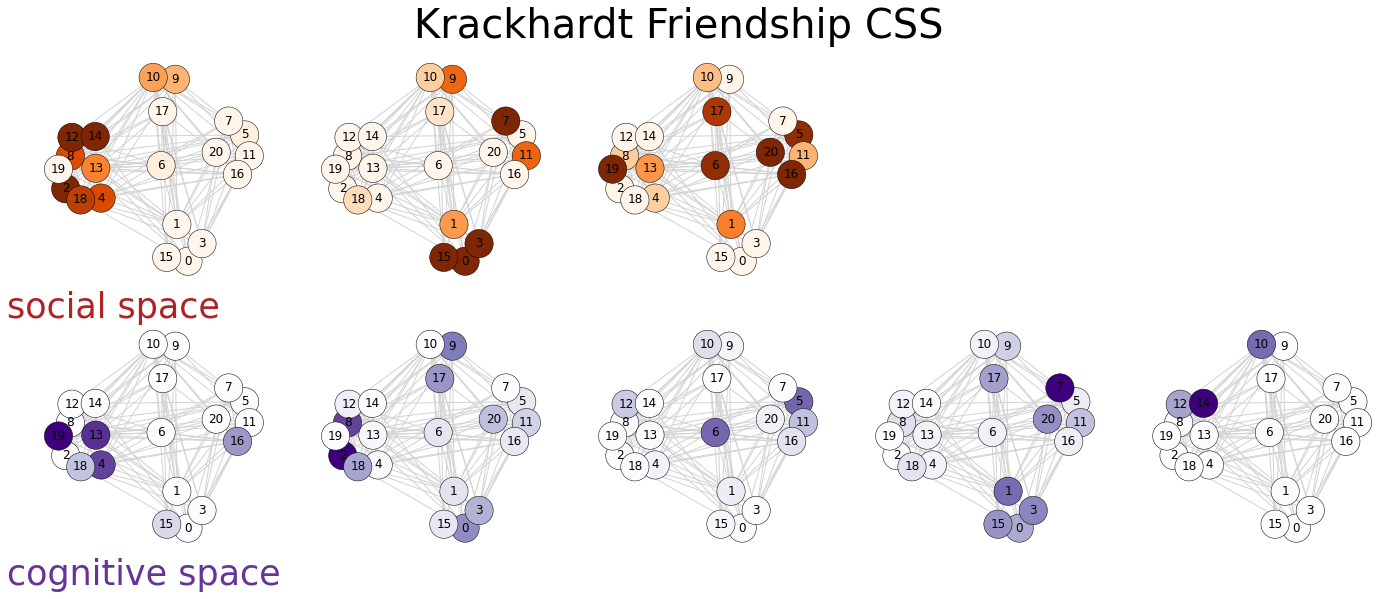

In [170]:

for n in range(1):
    f, axis = plt.subplots(2,5)
    f.set_figheight(9)
    f.set_figwidth(24)
    colors_U1 = ['c'] * len(krackf_and)
    colors_U2 = ['c'] * len(krackf_and)
    colors_U3 = ['c'] * len(krackf_and)
    colors_Y1 = ['c'] * len(krackf_and)
    colors_Y2 = ['c'] * len(krackf_and)
    colors_Y3 = ['c'] * len(krackf_and)
    colors_Y4 = ['c'] * len(krackf_and)
    colors_Y4 = ['c'] * len(krackf_and)
    colors_Y5 = ['c'] * len(krackf_and)
    Ytwo, Utwo, Vtwo = factors_fr
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krackf_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
        colors_Y4[i] = cmapTwo(Y_norm[i, 3])
        colors_Y5[i] = cmapTwo(Y_norm[i, 4])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(krackf_Network, posrep,  ax=axis[0,1], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,0], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,2], node_color=colors_U3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,1], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,0], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,3], node_color=colors_Y4, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,3].collections[0].set_edgecolor("k") 
    axis[1,3].collections[0].set_linewidths(0.5)
    
    nx.draw(krackf_Network, posrep,  ax=axis[1,4], node_color=colors_Y5, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,4].collections[0].set_edgecolor("k") 
    axis[1,4].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(2.7, 1.2, 'Krackhardt Friendship CSS', fontsize = 40, c = 'k')
    axis[0,0].text(-1.5, -1.4, 'social space', fontsize = 35, c = 'firebrick')
    axis[1,0].text(-1.5, -1.4, 'cognitive space', fontsize = 35, c = 'rebeccapurple')
    
    axis[0, 3].axis('off')
    axis[0, 4].axis('off')
    filename = 'krackf_cognet_max_3_5.pdf'
    plt.savefig(filename, bbox_inches='tight')

In [160]:
core_fr_SCA, factors_fr_SCA, loglike_fr_SCA =  multistart(krack_f, C = 3, K = 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'SCA')

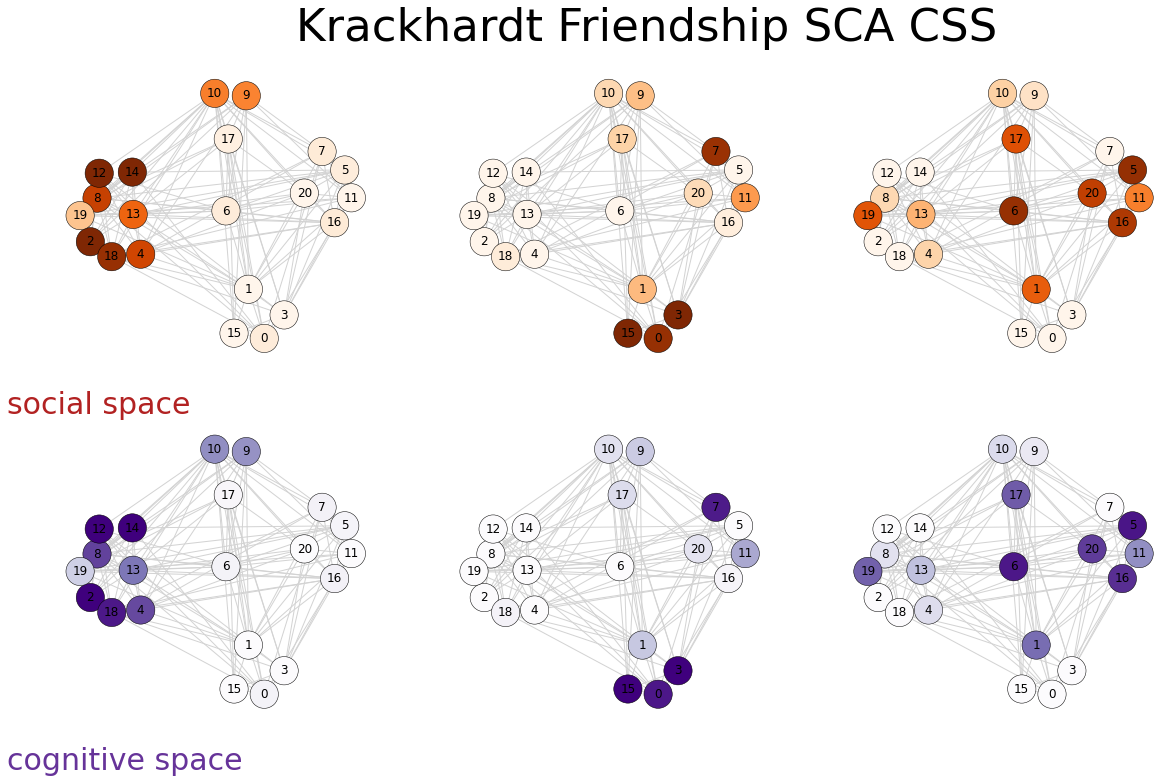

In [169]:

for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krackf_and)
    colors_U2 = ['c'] * len(krackf_and)
    colors_U3 = ['c'] * len(krackf_and)
    colors_Y1 = ['c'] * len(krackf_and)
    colors_Y2 = ['c'] * len(krackf_and)
    colors_Y3 = ['c'] * len(krackf_and)
    Ytwo, Utwo, Vtwo = factors_fr_SCA
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krackf_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])

        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(krackf_Network, posrep,  ax=axis[0,1], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,0], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[0,2], node_color=colors_U3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,1], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(krackf_Network, posrep,  ax=axis[1,0], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)

    
    axis[0,0].text(.6, 1.2, 'Krackhardt Friendship SCA CSS', fontsize = 45, c = 'k')
    axis[0,0].text(-1.5, -1.4, 'social space', fontsize = 30, c = 'firebrick')
    axis[1,0].text(-1.5, -1.4, 'cognitive space', fontsize = 30, c = 'rebeccapurple')
    
    filename = 'krackf_cognet_max_SCA.pdf'
    plt.savefig(filename, bbox_inches='tight')

# Hunter Advice

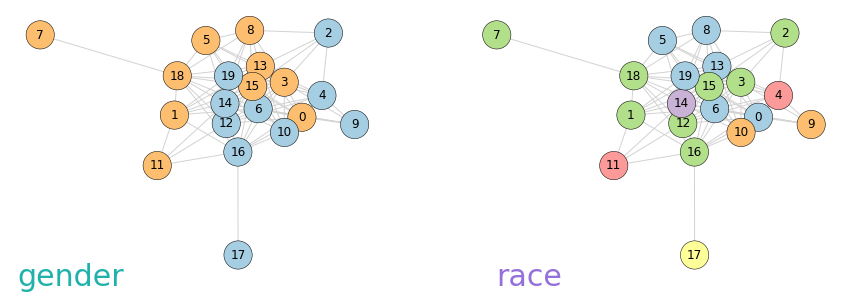

In [53]:
save_fig = False 
C = gender
cmap = cmx.get_cmap(name='Paired')
N = len(fr_network.nodes())
K = len(C)
color_map = ['k']*N
for i in range(K):
    for j in range(len(C[i])):
        color_map[ C[i][j] ] = cmap(i/K)
C = race
cmap = cmx.get_cmap(name='Paired')
N = len(fr_network.nodes())
K = len(C)
color_map2 = ['k']*N
for i in range(K):
    for j in range(len(C[i])):
        color_map2[ C[i][j] ] = cmap(i/K)
fig, axis = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
nx.draw(fr_network1, pos_hunter2, ax = axis[0], node_color=color_map, node_size=800, edge_color='lightgrey', with_labels=True)

axis[0].text(-1, -1.2, 'gender', fontsize = 30, c = 'lightseagreen')
axis[0].collections[0].set_edgecolor("k") 
axis[0].collections[0].set_linewidths(0.5)
nx.draw(fr_network1, pos_hunter2, ax = axis[1], node_color=color_map2, node_size=800, edge_color='lightgrey', with_labels=True)
axis[1].collections[0].set_edgecolor("k") 
axis[1].collections[0].set_linewidths(0.5)
axis[1].text(-.9, -1.2, 'race', fontsize = 30, c = 'mediumpurple')
if save_fig:
    filename = 'hunterf0_gender.pdf'
    plt.savefig(filename, bbox_inches='tight')

In [402]:
core_huntera, factors_huntera, loglike_huntera =  multistart(hunter_a[-1], C = 20, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'Ind')

In [ ]:
np.save(core_huntera, 'huntera_core')
np.save(factors_huntera, 'huntera_factors')

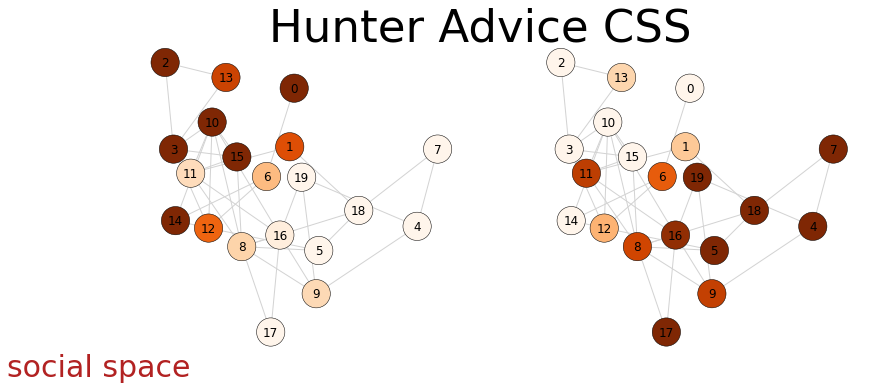

In [408]:

for n in range(1):
    f, axis = plt.subplots(1,2)
    f.set_figheight(6)
    f.set_figwidth(13)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    colors_Y3 = ['c'] * len(advice_truth_6)
#     colors_Y4 = ['c'] * len(advice_truth_6)
    Ytwo, Utwo, Vtwo = factors_huntera
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
#         colors_Y1[i] = cmapTwo(Y_norm[i, 0])
#         colors_Y2[i] = cmapTwo(Y_norm[i, 1])
#         colors_Y3[i] = cmapTwo(Y_norm[i, 2])
#         colors_Y4[i] = cmapTwo(Y_norm[i, 3])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(ad_network, pos,  ax=axis[1], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1].collections[0].set_edgecolor("k") 
    axis[1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[0], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0].collections[0].set_edgecolor("k") 
    axis[0].collections[0].set_linewidths(0.5)
#     nx.draw(ad_network, pos,  ax=axis[1,1], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
#     axis[1,1].collections[0].set_edgecolor("k") 
#     axis[1,1].collections[0].set_linewidths(0.5)
#     nx.draw(ad_network, pos,  ax=axis[1,2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
#     axis[1,2].collections[0].set_edgecolor("k") 
#     axis[1,2].collections[0].set_linewidths(0.5)
#     nx.draw(ad_network, pos,  ax=axis[1,0], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
#     axis[1,0].collections[0].set_edgecolor("k") 
#     axis[1,0].collections[0].set_linewidths(0.5)
#     nx.draw(ad_network, pos,  ax=axis[1,3], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
#     axis[1,3].collections[0].set_edgecolor("k") 
#     axis[1,3].collections[0].set_linewidths(0.5)
    
    axis[0].text(0, 1, 'Hunter Advice CSS', fontsize = 45, c = 'k')
    axis[0].text(-1.5, -1.3, 'social space', fontsize = 30, c = 'firebrick')
#     axis[1,0].text(-1.5, -1.3, 'cognitive space', fontsize = 30, c = 'rebeccapurple')
    
#     axis[0, 2].axis('off')
#     axis[0, 3].axis('off')
    filename = 'huntera_cognet_max_ind.pdf'
    plt.savefig(filename, bbox_inches='tight')

In [77]:
core_huntera_SCA, factors_huntera_SCA, loglike_huntera_SCA =  multistart(hunter_a[-1], C = 2, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'SCA')

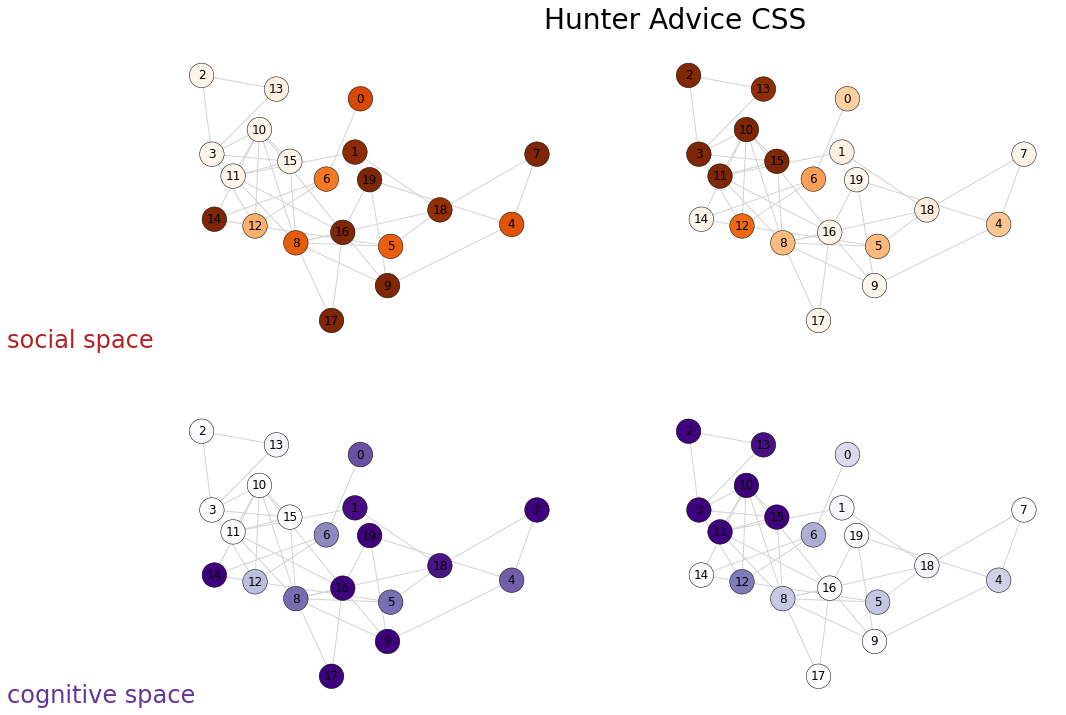

In [82]:

for n in range(1):
    f, axis = plt.subplots(2,2)
    f.set_figheight(12)
    f.set_figwidth(16)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    Ytwo, Utwo, Vtwo = factors_huntera_SCA
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(ad_network, pos,  ax=axis[0,1], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[0,0], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(ad_network, pos,  ax=axis[1,0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Hunter Advice CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    filename = 'huntera_cognet_max_SCA.pdf'
    plt.savefig(filename,bbox_inches='tight')

# Hunter Friendship

In [54]:
save_NNTuck = True
core_hunterf, factors_hunterf, loglike_hunterf =  multistart(hunter_f[-1], C = 3, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')
if save_NNTuck:
    np.save('hunterf_core', core_hunterf)
    np.save('hunterf_factors', factors_hunterf)

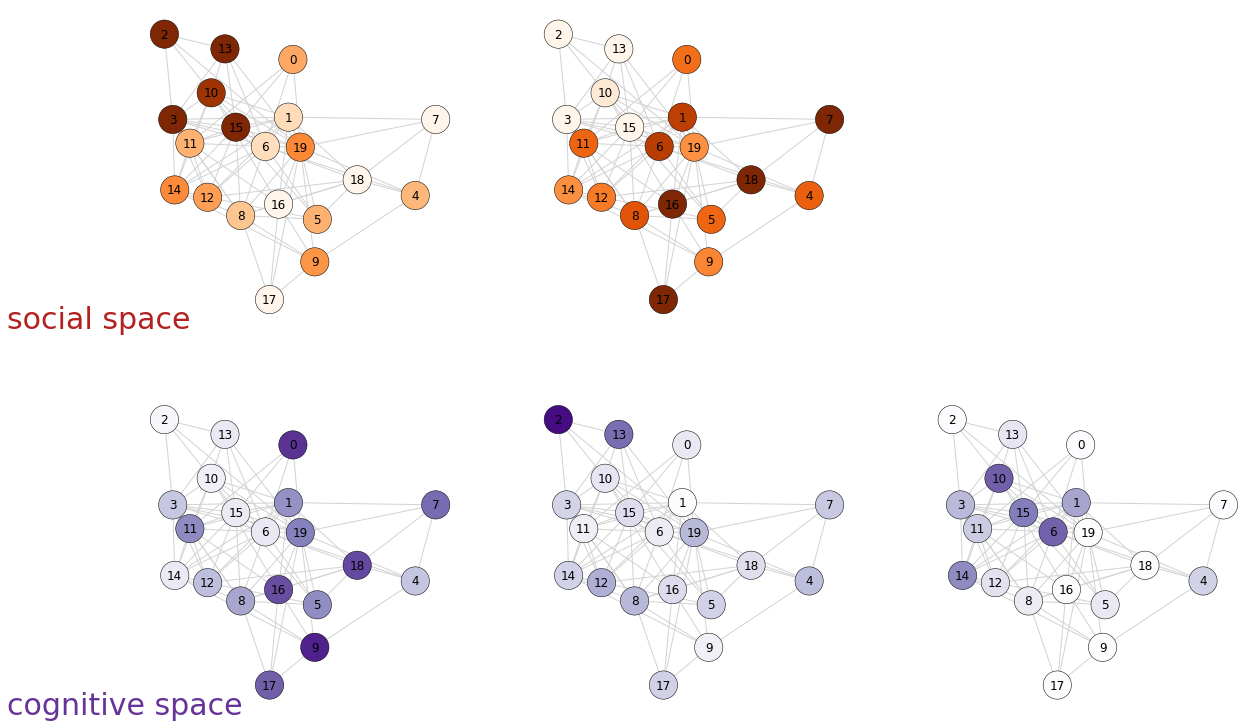

In [86]:
save_fig = True
for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(13)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    colors_Y3 = ['c'] * len(advice_truth_6)


    Ytwo, Utwo, Vtwo = factors_hunterf
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])

    nx.draw(fr_network, pos,  ax=axis[0,1], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[0,0], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[1,1], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[1,2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos,  ax=axis[1,0], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
#     axis[0,0].text(-.5, 1.1, 'Hunter Friendship CSS, Last Week', fontsize = 45, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 30, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 30, c = 'rebeccapurple')
    axis[0, 2].axis('off')
    if save_fig:
        filename = 'hunterf_cognet_max_2_3_regpos.pdf'
        plt.savefig(filename, bbox_inches='tight')
        #plt.close()

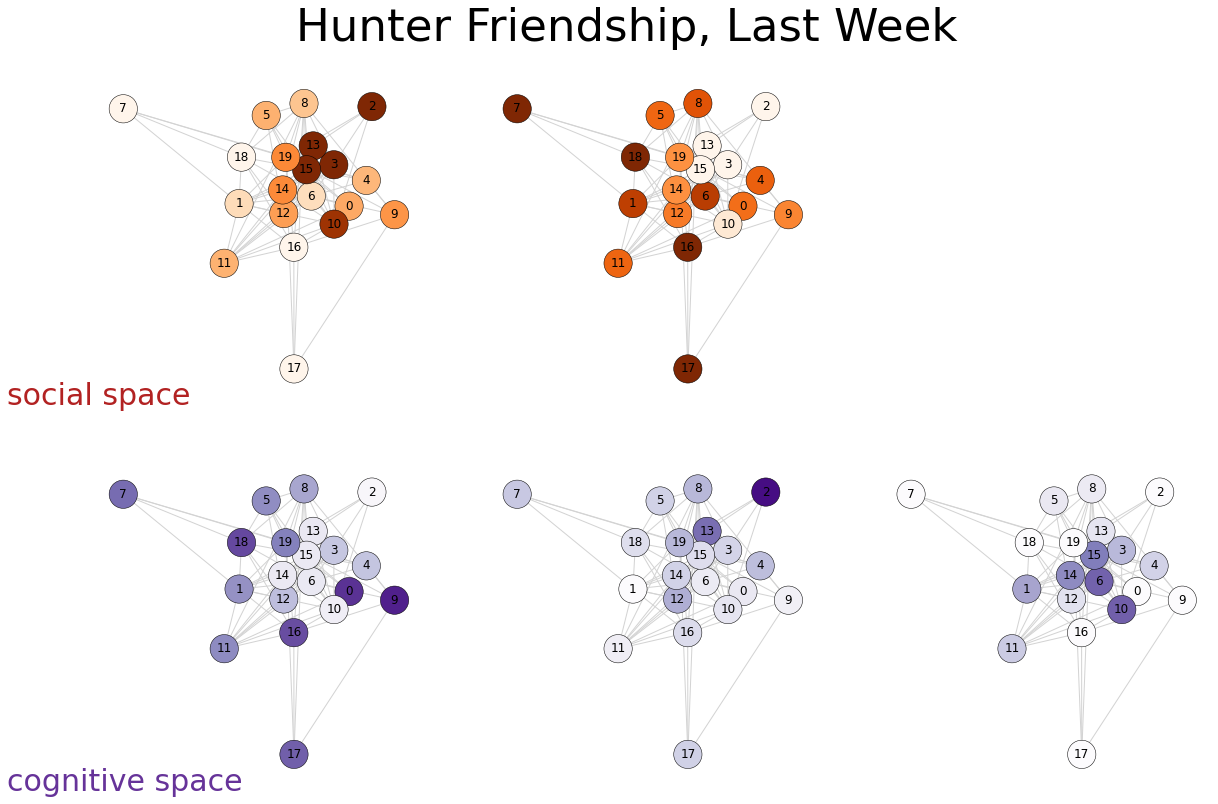

In [80]:
save_fig = True
for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(13)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    colors_Y3 = ['c'] * len(advice_truth_6)


    Ytwo, Utwo, Vtwo = factors_hunterf
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])

    nx.draw(fr_network, pos_hunter,  ax=axis[0,1], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos_hunter,  ax=axis[0,0], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos_hunter,  ax=axis[1,1], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos_hunter,  ax=axis[1,2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(fr_network, pos_hunter,  ax=axis[1,0], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(0, .8, 'Hunter Friendship, Last Week', fontsize = 45, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 30, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 30, c = 'rebeccapurple')
    axis[0, 2].axis('off')
    if save_fig:
        filename = 'hunterf_cognet_max_2_3.pdf'
        plt.savefig(filename, bbox_inches='tight')
        #plt.close()

In [67]:
save_NNTuck = False
core_hunterf0, factors_hunterf0, loglike_hunterf0 =  multistart(hunter_f[0], C = 2, K = 2, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')
if save_NNTuck:
    np.save('hunterf0_core', core_hunterf0)
    np.save('hunterf0_factors', factors_hunterf0)

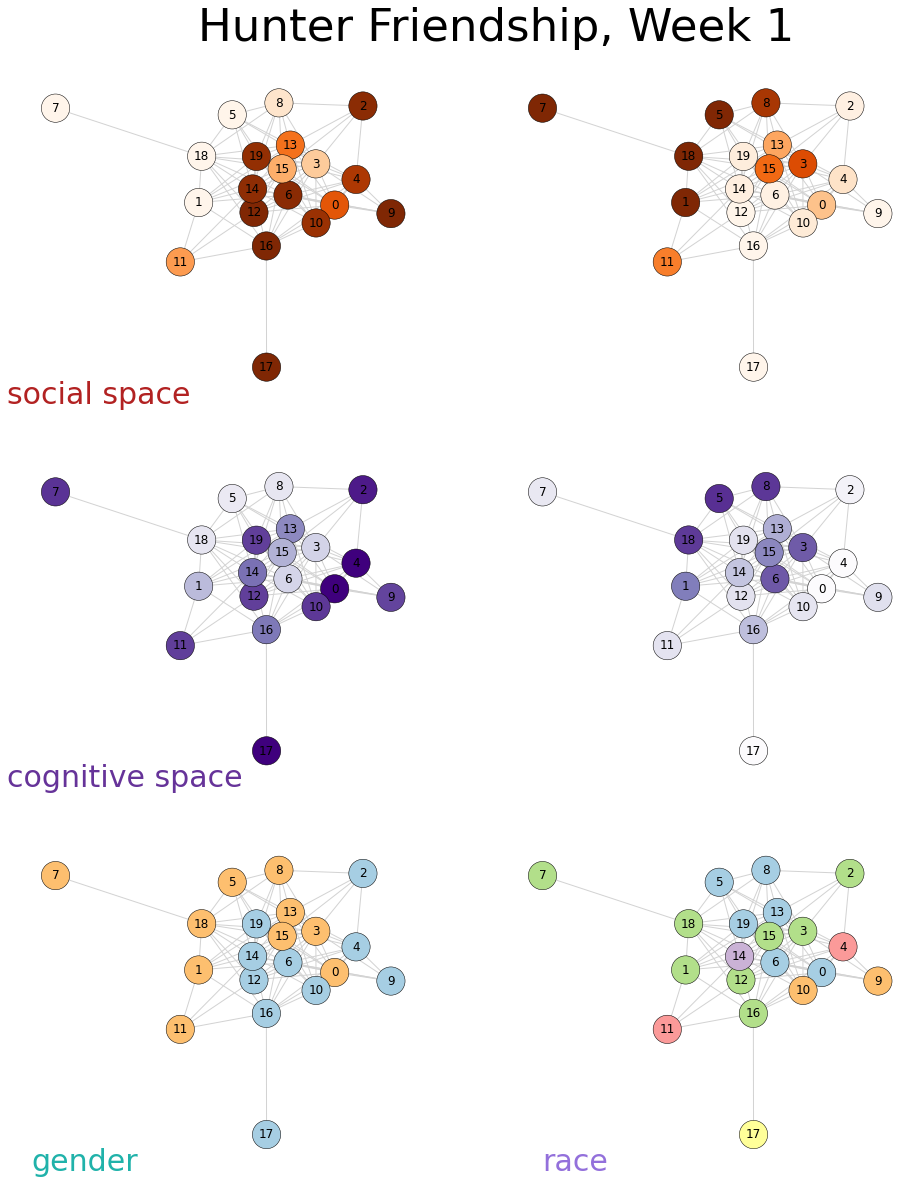

In [85]:
save_fig=True
for n in range(1):
    f, axis = plt.subplots(3,2)
    f.set_figheight(20)
    f.set_figwidth(16)
    colors_U1 = ['c'] * len(advice_truth_6)
    colors_U2 = ['c'] * len(advice_truth_6)
    colors_Y1 = ['c'] * len(advice_truth_6)
    colors_Y2 = ['c'] * len(advice_truth_6)
    colors_Y3 = ['c'] * len(advice_truth_6)
    colors_Y4 = ['c'] * len(advice_truth_6)
    colors_Y5 = ['c'] * len(advice_truth_6)

    Ytwo, Utwo, Vtwo = factors_hunterf0
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(friend_truth_6)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
#         colors_Y3[i] = cmapTwo(Y_norm[i, 2])
#         colors_Y4[i] = cmapTwo(Y_norm[i, 3])
#         colors_Y5[i] = cmapTwo(Y_norm[i, 4])

    nx.draw(fr_network1, pos_hunter,  ax=axis[0,1], node_color=colors_U2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(fr_network1, pos_hunter,  ax=axis[0,0], node_color=colors_U1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(fr_network1, pos_hunter,  ax=axis[1,1], node_color=colors_Y1, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
#     nx.draw(fr_network, pos,  ax=axis[1,2], node_color=colors_Y3, node_size=800, edge_color='lightgrey', with_labels=True)
#     axis[1,2].collections[0].set_edgecolor("k") 
#     axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(fr_network1, pos_hunter,  ax=axis[1,0], node_color=colors_Y2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
#     nx.draw(fr_network, pos,  ax=axis[1,3], node_color=colors_Y4, node_size=800, edge_color='lightgrey', with_labels=True)
#     axis[1,3].collections[0].set_edgecolor("k") 
#     axis[1,3].collections[0].set_linewidths(0.5)
#     nx.draw(fr_network, pos,  ax=axis[1,4], node_color=colors_Y5, node_size=800, edge_color='lightgrey', with_labels=True)
#     axis[1,4].collections[0].set_edgecolor("k") 
#     axis[1,4].collections[0].set_linewidths(0.5)
    nx.draw(fr_network1, pos_hunter, ax = axis[2,0], node_color=color_map, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[2,0].text(-1, -1.2, 'gender', fontsize = 30, c = 'lightseagreen')
    axis[2,0].collections[0].set_edgecolor("k") 
    axis[2,0].collections[0].set_linewidths(0.5)
    nx.draw(fr_network1, pos_hunter, ax = axis[2,1], node_color=color_map2, node_size=800, edge_color='lightgrey', with_labels=True)
    axis[2,1].collections[0].set_edgecolor("k") 
    axis[2,1].collections[0].set_linewidths(0.5)
    axis[2,1].text(-.9, -1.2, 'race', fontsize = 30, c = 'mediumpurple')
    axis[0,0].text(-0.3, .8, 'Hunter Friendship, Week 1', fontsize = 45, c = 'k')
    axis[0,0].text(-1.1, -1.2, 'social space', fontsize = 30, c = 'firebrick')
    axis[1,0].text(-1.1, -1.2, 'cognitive space', fontsize = 30, c = 'rebeccapurple')
#     axis[0, 2].axis('off')
    if save_fig:
        filename = 'hunterf0_cognet_max_2_2.pdf'
        plt.savefig(filename, bbox_inches='tight')
        #plt.close()